***No Broker***
<br>
**Property Click Prediction**

<p>
We are interested in studying and statistically modelling property interactions. We would like to have a predictive model that would say the number of interactions that a property would receive in a period of time. For simplicity let’s say we would like to predict the number of interactions that a property would receive within x days of its activation. We will figure out an ideal value for x after some exploration.
    </p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import PoissonRegressor

%matplotlib inline

In [3]:
property_data = pd.read_csv('./datasets/property_data_set.csv')
property_interactions = pd.read_csv('./datasets/property_interactions.csv')
property_photos = pd.read_csv('./datasets/property_photos.tsv',sep = '\t')

***

<p>We will extract the number of photos from the property_photos urls</p>

In [4]:
property_photos.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


(Use code provided from stratascratch solution)

In [5]:
def photo_count(photo_input):
    """
    Use regex to count unique instances of 'IMG_' in the list
    """
    if photo_input is np.nan or photo_input == 'NaN':
        return 0
    else:
        jpg_files = photo_input.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","')
        return len(json.loads(jpg_files))

In [6]:
property_photos['num_photos'] = property_photos['photo_urls'].apply(photo_count)

In [7]:
del property_photos['photo_urls']

In [8]:
property_photos.head()

,property_id,num_photos
0,ff808081469fd6e20146a5af948000ea,7
1,ff8080814702d3d10147068359d200cd,0
2,ff808081470c645401470fb03f5800a6,12
3,ff808081470c6454014715eaa5960281,9
4,ff808081474aa867014771a0298f0aa6,7


***

<p>The property_interactions df has a row for each valid interaction on a property (contact owner happened and a user received the owner contact phone number) </p>

In [9]:
property_interactions.head()

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15


***

<p>The property_data df has a row for each property showing all the specifics like activation date and other details.</p>

<p> For each property in the interactions table, we will append the activation date and add a column for number of days between activation and request. We will see at what point the requests start to stabilize on average. This will be our cutoff for building the model. Note that activation_date is formatted as day-month-year </p>

In [10]:
data_interaction = property_interactions.merge(property_data[['property_id','activation_date']],on='property_id',
                                              how= 'inner')


data_interaction['request_date_formatted'] = pd.to_datetime(data_interaction['request_date'], format='%Y-%m-%d %H:%M').dt.strftime('%Y-%m-%d')
data_interaction['activated_date_formatted'] = pd.to_datetime(data_interaction['activation_date'], format='%d-%m-%Y %H:%M').dt.strftime('%Y-%m-%d')
data_interaction['days_diff'] = (pd.to_datetime(data_interaction['request_date_formatted']) \
                - pd.to_datetime(data_interaction['activated_date_formatted'])).dt.days

# Apply the condition to return 1 if days_diff is 0, otherwise return the number itself
data_interaction['days_diff'] = data_interaction['days_diff'].apply(lambda x: 1 if x == 0 else x)

In [11]:
columns_to_drop = ['activation_date', 'request_date','activated_date_formatted','request_date_formatted']
data_interaction = data_interaction.drop(columns=columns_to_drop)

In [12]:
data_interaction.groupby(['property_id','days_diff'])['days_diff'] \
         .count() \
         .reset_index(name='count').groupby('days_diff')['count'].sum()[:60]

days_diff
1     19895
2     11319
3     10057
4      8712
5      8254
6      7599
7      6900
8      6077
9      5860
10     5479
11     5121
12     4816
13     4531
14     4378
15     4312
16     3925
17     3757
18     3538
19     3296
20     3068
21     2995
22     2867
23     2668
24     2535
25     2390
26     2259
27     2095
28     1911
29     1933
30     1780
31     1590
32     1533
33     1341
34     1371
35     1296
36     1201
37     1088
38     1059
39      903
40      865
41      827
42      810
43      688
44      706
45      681
46      106
47       25
48       17
49       15
50       19
51       18
52        5
53       15
54        6
55       10
56       11
57       11
58       10
59       10
60        8
Name: count, dtype: int64

<br>

<br>

Below we plot the total interactions on any property by days since activation.

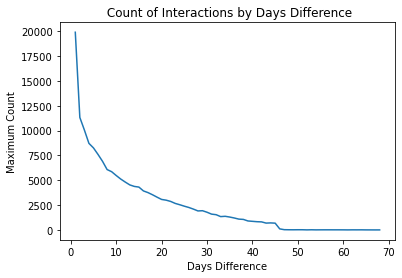

In [13]:
plt.plot(data_interaction.groupby(['property_id','days_diff'])['days_diff'] \
         .count() \
         .reset_index(name='count').groupby('days_diff')['count'].sum())

plt.xlabel('Days Difference')
plt.ylabel('Maximum Count')
plt.title(' Count of Interactions by Days Difference')

plt.show()

<p> The elbow point is right around two weeks so we will try to predict interactions after 13 days.</p>

For each property, add 13 days after activation

In [14]:
total_interactions_13_days = data_interaction.loc[data_interaction['days_diff']<=13].groupby('property_id')['days_diff'] \
                            .count() \
                            .reset_index(name = 'total_interactions')

Note certain properties will be excluded as they may not have had any interactions in the first 13 days.

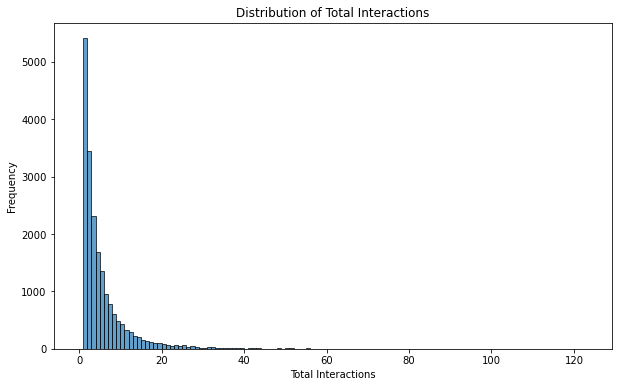

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(total_interactions_13_days['total_interactions'], \
         bins=range(0, max(total_interactions_13_days['total_interactions'])), edgecolor='black', alpha=0.7)

plt.xlabel('Total Interactions')
plt.ylabel('Frequency')
plt.title('Distribution of Total Interactions')

plt.show()

<br>

<br>

<br>

***

<p> Feature Handling </p>

In [16]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28888 entries, 0 to 28887
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_id      28888 non-null  object 
 1   type             28888 non-null  object 
 2   activation_date  28888 non-null  object 
 3   bathroom         28888 non-null  int64  
 4   floor            28888 non-null  int64  
 5   total_floor      28845 non-null  float64
 6   furnishing       28888 non-null  object 
 7   gym              28888 non-null  int64  
 8   latitude         28888 non-null  float64
 9   longitude        28888 non-null  float64
 10  lease_type       28888 non-null  object 
 11  lift             28888 non-null  int64  
 12  locality         28888 non-null  object 
 13  parking          28888 non-null  object 
 14  property_age     28888 non-null  int64  
 15  property_size    28888 non-null  int64  
 16  swimming_pool    28888 non-null  int64  
 17  pin_code    

<br>

<p> The type represents the style of residence. For example BHK2 means 2 bedroom and RK1 is essentially a studio. Still unclear what building type and total floor means. Will ignore pin (zip) code and total floors.</p>

In [17]:
# Loop through columns and print unique values for 'object' dtype columns
for column in property_data.select_dtypes(include='object').columns:
    print(f"Unique values in column '{column}':")
    print(property_data[column].unique())
    print()

Unique values in column 'property_id':
['ff808081469fd6e20146a5af948000ea' 'ff8080814702d3d10147068359d200cd'
 'ff808081470c645401470fb03f5800a6' ... 'ff8081815b1fdda8015b2000369205fd'
 'ff8081815b200540015b20158b0103c9' 'ff8081815b2007fc015b201c77a20395']

Unique values in column 'type':
['BHK2' 'BHK3' 'BHK1' 'RK1' 'BHK4' 'BHK4PLUS']

Unique values in column 'activation_date':
['09-03-2017 14:36' '07-03-2017 12:02' '10-03-2017 13:43' ...
 '30-03-2017 21:47' '30-03-2017 22:30' '30-03-2017 22:33']

Unique values in column 'furnishing':
['SEMI_FURNISHED' 'NOT_FURNISHED' 'FULLY_FURNISHED']

Unique values in column 'lease_type':
['FAMILY' 'ANYONE' 'BACHELOR' 'COMPANY']

Unique values in column 'locality':
['Hulimavu' 'Ramamurthy Nagar' 'GM Palya' ... 'BTM Layout 1 stage'
 'Kammanahalli,Banswadi' 'Hosakote']

Unique values in column 'parking':
['BOTH' 'FOUR_WHEELER' 'TWO_WHEELER' 'NONE']

Unique values in column 'building_type':
['AP' 'IF' 'IH' nan]



In [18]:
property_data.describe()

,bathroom,floor,total_floor,gym,latitude,longitude,lift,property_age,property_size,swimming_pool,pin_code,rent,deposit
count,28888.000000,28888.000000,28845.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,2.856300e+04,28888.000000,2.888800e+04
mean,1.795867,1.786659,3.518807,0.165951,12.957859,77.605186,0.279009,4.380539,966.338999,0.142585,5.615600e+05,14430.768797,1.233257e+05
std,0.778676,2.361768,3.362536,0.372043,0.219500,0.921003,0.448520,7.458914,619.390016,0.349655,8.979452e+04,9055.133718,1.255028e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1000.000000,0.000000e+00
25%,1.000000,0.000000,2.000000,0.000000,12.906324,77.563295,0.000000,0.000000,600.000000,0.000000,5.600400e+05,8000.000000,5.000000e+04
50%,2.000000,1.000000,3.000000,0.000000,12.953939,77.614568,0.000000,3.000000,900.000000,0.000000,5.600670e+05,12500.000000,1.000000e+05
75%,2.000000,2.000000,4.000000,0.000000,13.009369,77.669235,1.000000,6.000000,1200.000000,0.000000,5.600840e+05,18000.000000,1.500000e+05
max,22.000000,123.000000,38.000000,1.000000,21.176277,80.256293,1.000000,800.000000,40000.000000,1.000000,5.601000e+06,75000.000000,4.200000e+06


We will plot the areas using the lat and long values

In [19]:
lat = property_data['latitude'].values
lon = property_data['longitude'].values

In [20]:
gdf = gpd.GeoDataFrame(property_data, geometry=gpd.points_from_xy(property_data['longitude'], property_data['latitude']))


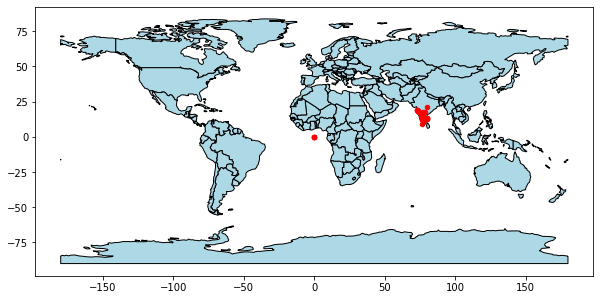

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='lightblue', edgecolor='black')

gdf.plot(ax=ax, color='red', markersize=20)

plt.show()

Notice some properties with problematic lat long values at 0,0. Though it likely will not make a dramatic difference, we will fix these using the most common lat long for the specified pin code.

In [22]:
modes = property_data.groupby('pin_code')[['longitude', 'latitude']].agg(pd.Series.mode)

def replace_with_mode(row):
    if row['latitude'] == 0 and row['longitude'] == 0: 
        row['latitude'] = modes.loc[row['pin_code'], 'latitude'].mean()
        row['longitude'] = modes.loc[row['pin_code'], 'longitude'].mean()
    return row

# Apply the replacement
property_data = property_data.apply(replace_with_mode, axis=1)

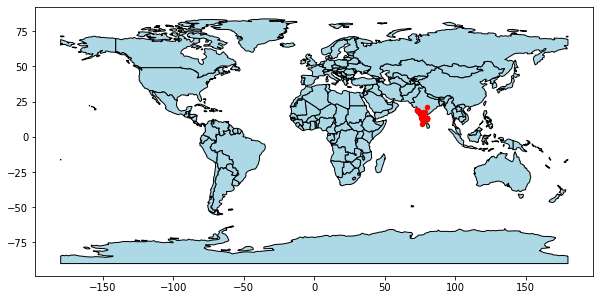

In [23]:
lat = property_data['latitude'].values
lon = property_data['longitude'].values

gdf = gpd.GeoDataFrame(property_data, geometry=gpd.points_from_xy(property_data['longitude'], property_data['latitude']))
india = world[world['name'] == 'India']
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='lightblue', edgecolor='black')

gdf.plot(ax=ax, color='red', markersize=20)

plt.show()

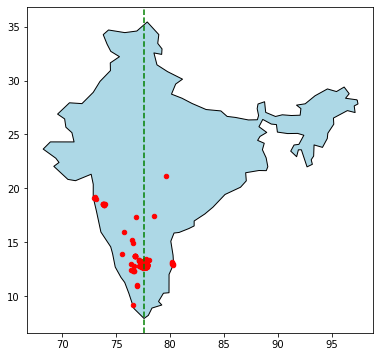

In [24]:
india = world[world['name'] == 'India']
ax = india.plot(figsize=(10, 6), color='lightblue', edgecolor='black')

gdf.plot(ax=ax, color='red', markersize=20)
longitude_to_mark = 77.6
plt.axvline(x=longitude_to_mark, color='green', linestyle='--', linewidth=1.5, label=f'Longitude {longitude_to_mark}')

plt.show()

All the properties are in the south of India. We will add a variable to separate them by east and west.

Anything less than a longitude of 77.6 will be considered west while the rest will be considered east.

Will just use a binary variable called is_west

In [25]:
property_data['is_west'] = (property_data['longitude'] <= 77.6).astype(int)


In [26]:
property_data['is_west'].value_counts()

0    16769
1    12119
Name: is_west, dtype: int64

Another interesting variable that could be added is whether or not the property is along the coast line. We will not add that here.

We will now begin filling any missing values if necessary

In [27]:
del property_data['geometry']

In [28]:
exclude_columns = ['total_floor', 'locality','pin_code']
property_data = property_data[[col for col in property_data.columns if col not in exclude_columns]]

In [29]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28888 entries, 0 to 28887
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_id      28888 non-null  object 
 1   type             28888 non-null  object 
 2   activation_date  28888 non-null  object 
 3   bathroom         28888 non-null  int64  
 4   floor            28888 non-null  int64  
 5   furnishing       28888 non-null  object 
 6   gym              28888 non-null  int64  
 7   latitude         28888 non-null  float64
 8   longitude        28888 non-null  float64
 9   lease_type       28888 non-null  object 
 10  lift             28888 non-null  int64  
 11  parking          28888 non-null  object 
 12  property_age     28888 non-null  int64  
 13  property_size    28888 non-null  int64  
 14  swimming_pool    28888 non-null  int64  
 15  rent             28888 non-null  int64  
 16  deposit          28888 non-null  int64  
 17  building_typ

We will try to fill out the missing values in building_type by using the most common building type for each 'type'

In [30]:
modes = property_data.groupby('type')[['building_type']].agg(pd.Series.mode)

def replace_with_mode(row):
    if pd.isna(row['building_type']):
        row['building_type'] = modes.loc[row['type'], 'building_type']
    return row


property_data = property_data.apply(replace_with_mode, axis=1)

Map the type variable to get number of rooms in the property.

In [31]:
mapping = {
    'RK1': 0,
    'BHK1': 1,
    'BHK2': 2,
    'BHK3': 3,
    'BHK4': 4,
    'BHK4PLUS': 4
}

property_data['num_rooms'] = property_data['type'].map(mapping)

Extract the activation month and day of week.

In [32]:
property_data['activation_month'] = pd.to_datetime(property_data['activation_date'], format='%d-%m-%Y %H:%M') \
                                    .dt.month

property_data['activation_day_of_week'] = pd.to_datetime(property_data['activation_date'], format='%d-%m-%Y %H:%M') \
                                        .dt.day_name()

In [33]:
property_data = property_data.merge(property_photos,on = 'property_id',how = 'left')

In [34]:
property_data = property_data.merge(total_interactions_13_days,on = 'property_id',how = 'left')

In [35]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28888 entries, 0 to 28887
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_id             28888 non-null  object 
 1   type                    28888 non-null  object 
 2   activation_date         28888 non-null  object 
 3   bathroom                28888 non-null  int64  
 4   floor                   28888 non-null  int64  
 5   furnishing              28888 non-null  object 
 6   gym                     28888 non-null  int64  
 7   latitude                28888 non-null  float64
 8   longitude               28888 non-null  float64
 9   lease_type              28888 non-null  object 
 10  lift                    28888 non-null  int64  
 11  parking                 28888 non-null  object 
 12  property_age            28888 non-null  int64  
 13  property_size           28888 non-null  int64  
 14  swimming_pool           28888 non-null

In [36]:
mapping = {
    'NOT_FURNISHED': 0,
    'SEMI_FURNISHED': 1,
    'FULLY_FURNISHED': 2
}

property_data['furnished_encoded'] = property_data['furnishing'].map(mapping)

In [37]:
weekend_mapping = {
    'Monday': 0,
    'Tuesday': 0,
    'Wednesday': 0,
    'Thursday': 0,
    'Friday': 1,
    'Saturday': 1,
    'Sunday': 1
}

property_data['is_weekend'] = property_data['activation_day_of_week'].map(weekend_mapping)

In [38]:
vehicle_mapping = {
    'NONE': 0,
    'BOTH': 1,
    'FOUR_WHEELER': 1,
    'TWO_WHEELER': 1
}

property_data['parking_binary'] = property_data['parking'].map(vehicle_mapping)

In [39]:
# One-hot encode the columns
building_type_encoded = pd.get_dummies(property_data['building_type'], prefix='building_type')
lease_type_encoded = pd.get_dummies(property_data['lease_type'], prefix='lease_type')

# Concatenate the one-hot encoded columns back into the original DataFrame
property_data = pd.concat([property_data, building_type_encoded, lease_type_encoded], axis=1)

***

***

***We will remove properties that got 0 interactions. Ideally we would have a separate classification model to see if an interaction occurs or not. We will not focus on that here.***

<br>

In [40]:
# property_data_cleaned = property_data.fillna(0)
property_data_cleaned = property_data.dropna()

In [41]:
property_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19913 entries, 0 to 28887
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_id             19913 non-null  object 
 1   type                    19913 non-null  object 
 2   activation_date         19913 non-null  object 
 3   bathroom                19913 non-null  int64  
 4   floor                   19913 non-null  int64  
 5   furnishing              19913 non-null  object 
 6   gym                     19913 non-null  int64  
 7   latitude                19913 non-null  float64
 8   longitude               19913 non-null  float64
 9   lease_type              19913 non-null  object 
 10  lift                    19913 non-null  int64  
 11  parking                 19913 non-null  object 
 12  property_age            19913 non-null  int64  
 13  property_size           19913 non-null  int64  
 14  swimming_pool           19913 non-null

In [42]:
features = ['bathroom','floor','furnished_encoded','gym'
                     ,'lease_type_ANYONE','lease_type_BACHELOR','lease_type_COMPANY',
                     'lease_type_FAMILY','lift','parking_binary','property_age','property_size',
                     'swimming_pool','rent','deposit','building_type_AP','building_type_IF','building_type_IH',
                     'is_west','num_rooms','is_weekend','num_photos']

dependent = ['total_interactions']


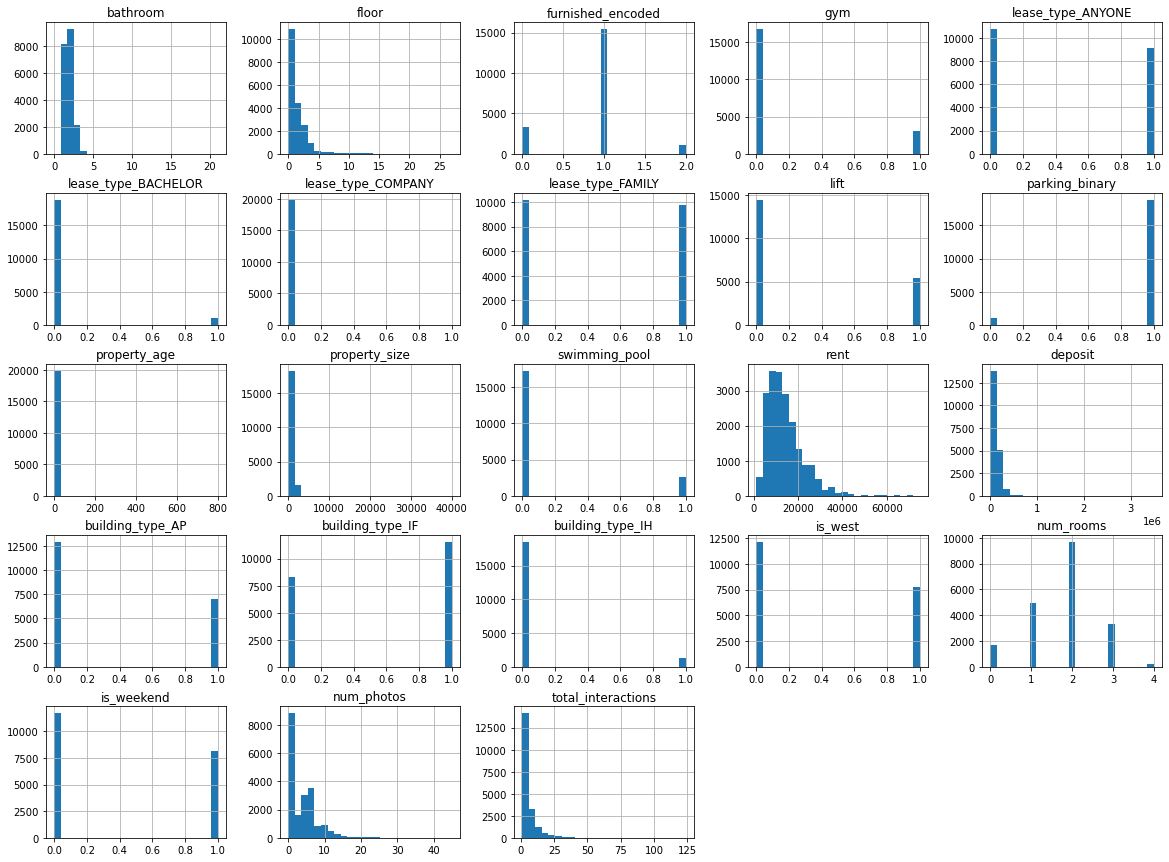

In [43]:
property_data_cleaned[features + dependent].hist(bins = 25,figsize = (20,15))
plt.show()

***

<br>

Now that we have added several variables and encoded others, we can split our data to begin building a model.

We begin by capping the response (total_interactions) to deal with outliers. We will cap anything over q3 + 1.5iqr at that value

In [44]:
Q1 = property_data_cleaned['total_interactions'].quantile(0.25)
Q3 = property_data_cleaned['total_interactions'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print("upper bound:",upper_bound)
# print("q3:", Q3)

upper bound: 13.5


In [45]:
# If 'property_data_cleaned' was derived from another DataFrame, make an explicit copy
property_data_cleaned = property_data_cleaned.copy()

# Now apply your transformation
property_data_cleaned.loc[:, 'total_interactions_cap'] = np.where(property_data_cleaned['total_interactions'] > 13, 13, property_data_cleaned['total_interactions'])


In [46]:
X_train, X_test, y_train, y_test = train_test_split(property_data_cleaned[features],
                                                    property_data_cleaned['total_interactions_cap'], test_size=0.2, random_state=42)

In [47]:
# Define the ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['bathroom', 'floor', 'property_age','property_size',
                                  'rent','deposit','num_photos']) ,
        ('cat', 'passthrough', list(set(features) - set(['bathroom', 'floor', 'property_age','property_size',
                                  'rent','deposit','num_photos'])))
    ])

# Fit and transform on the training data, then transform the test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

<br>

As we are modeling count data, we will fit a Poisson regression model. Assumptions unfortunately are not met as the response data exhibits overdispersion with the variance greater than the mean. In the future, we will explore using a negative binomial instead.

In [48]:
poisson_model = PoissonRegressor(alpha=1e-2) 
poisson_model.fit(X_train_scaled, y_train)

# Step 4: Make predictions
y_pred = poisson_model.predict(X_test_scaled)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error (MSE)
print("Root mean Squared Error (MSE):", np.sqrt(mse))

Root mean Squared Error (MSE): 3.653488192517882
